# CIFAR10 Classification w/ PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

c:\Users\qmirz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# set device GPU if aviailable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# define transformations for the data
transform = transforms.Compose(
    [transforms.ToTensor(), # convert the image to a tensor with values between 0 and 1 by dividing by 255
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize the data for each channel

In [8]:
# download cifar10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13542372.98it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


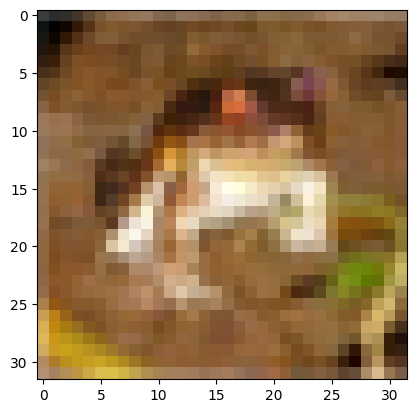

In [19]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np

# visualize the data
def show_img(img):
    img = img/2 + 0.5 # unnormalize the image & at this point it is a tensor
    npimg = img.numpy() # convert the tensor to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show() 

show_img(trainset[0][0])

In [27]:
# define data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [30]:
# define the model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 channels * 5x5 kernel
        self.fc2 = nn.Linear(120, 84) # 120 input channels, 84 output channels
        self.fc3 = nn.Linear(84, 10) # 84 input channels, 10 output channels

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # apply the first convolutional layer followed by activation of relu and pooling
        x = self.pool(torch.relu(self.conv2(x))) # apply the second convolutional layer followed by activation of relu and pooling
        x = x.view(-1, 16 * 5 * 5) # flatten the tensor
        x = torch.relu(self.fc1(x)) # apply the first fully connected layer followed by activation of relu
        x = torch.relu(self.fc2(x)) # apply the second fully connected layer followed by activation of relu
        x = self.fc3(x) # apply the third fully connected layer
        return x # return the output

In [31]:
# create an instance of the model
model = CNN().to(device)

In [32]:
loss_fn = nn.CrossEntropyLoss() # define the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # define the optimizer

In [33]:
# train the model
epochs = 10

for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 1.1069
Epoch [2/10], Loss: 1.2901
Epoch [3/10], Loss: 0.6672
Epoch [4/10], Loss: 1.8274
Epoch [5/10], Loss: 1.2249
Epoch [6/10], Loss: 0.9538
Epoch [7/10], Loss: 1.1849
Epoch [8/10], Loss: 0.8831
Epoch [9/10], Loss: 0.8913
Epoch [10/10], Loss: 0.7943


In [34]:
# evaluate the model
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += int((predicted == labels).sum())

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 63.43%


In [43]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [42]:
# plot a single model prediction's output
input_data = trainset[0][0].unsqueeze(0).to(device)

model.eval()

with torch.no_grad():
    predictions = model(input_data)

_, pred = torch.max(predictions, 1)

# actual label  
print(f"Actual Label: {trainset[0][1]} | Predicted Label: {pred.item()}")

Actual Label: 6 | Predicted Label: 6
